# Delay Network on BrainDrop

This notebook explores the implementation of a "delay network" (DN), i.e., a dynamical system optimized to represent a rolling window of input history, on the real BrainDrop. For technical details, see:
 - http://compneuro.uwaterloo.ca/publications/voelker2018.html
 - https://arvoelke.github.io/nengolib-docs/nengolib.networks.RollingWindow.html
 - https://github.com/arvoelke/cosyne2018/raw/master/abstract.pdf

In [33]:
%matplotlib inline

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

import nengo
import nengo_brainstorm as brd
from nengolib import Lowpass
from nengolib.networks import readout
from nengolib.signal import Balanced
from nengolib.synapses import PadeDelay, pade_delay_error, ss2sim

### Numerical Simulation

First, let's just look at the delay network's LTI system, and simulate it directly in discrete-time using the state-space equations:

$${\bf x}[t+1] = \bar{A} {\bf x}[t] + \bar{B} u[t] \text{.}$$

For debugging purposes, we compute the Padé approximation error for the given cut-off input frequency.

We also compute the optimal linear transformation that maps from the state-space back to the rolling window of input history. This gives us a way to efficiently compute functions across time within the lower-dimensional (temporally-compressed) space. Note the transformation accounts for the fact that the state-space has been "balanced".

In [35]:
theta = 0.1
order = 3
freq = 3
power = 1.5

print("PadeDelay(%s, %s) => %f%% error @ %sHz" % (
    theta, order, 100*abs(pade_delay_error(theta*freq, order=order)), freq))
pd = PadeDelay(theta=theta, order=order)

# Heuristic for normalizing state so that each dimension is ~[-1, +1]
rz = Balanced()(pd, radii=1./(np.arange(len(pd))+1))
sys = rz.realization

# Compute matrix to transform from state (x) -> sampled window (u)
t_samples = 100
C = np.asarray([readout(len(pd), r)
                for r in np.linspace(0, 1, t_samples)]).dot(rz.T)
assert C.shape == (t_samples, len(sys))

PadeDelay(0.1, 3) => 0.526057% error @ 3Hz


In [36]:
length = 100
dt = 0.05

process = nengo.processes.WhiteSignal(
    period=length*dt, rms=power, high=freq, y0=0, seed=0)
t = process.ntrange(length, dt=dt)
u = process.run_steps(length, dt=dt)
x = sys.X.filt(u, dt=dt)  # discretizes sys using ZOH

/home/truenorth/anaconda3/lib/python3.6/site-packages/nengolib/signal/system.py:717: UserWarning: Filtering with non-SISO systems is an experimental feature that may not behave as expected.
  "expected.", UserWarning)


/home/truenorth/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Radii: [0.97539117 0.75779965 0.61974777]


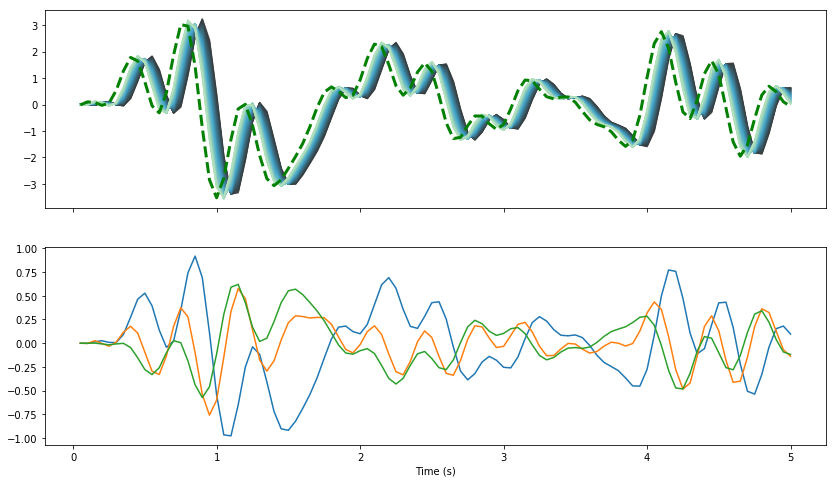

In [37]:
def plot(t, u, x, C=C):
    print("Radii:", np.max(np.abs(x), axis=0))
    w = C.dot(x.T)

    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(14, 8))
    for c, w_i in zip(sns.color_palette('GnBu_d', len(C)), w[::-1]):
        ax[0].plot(t, w_i, c=c, alpha=0.7)
    ax[0].plot(t, u, c='green', linestyle='--', lw=3)
    ax[1].plot(t, x)
    ax[-1].set_xlabel("Time (s)")
    fig.show()

plot(t, u, x)

### nengo_brainstorm (NEF on BrainDrop) Implementation

Now we apply "Principle 3" to map $\dot{{\bf x}}(t) = A{\bf x}(t) + Bu(t)$ onto a model for the synapse being used by BrainDrop. The input signal $u(t)$ is drawn from the same band-limited white noise process used above.

Each dimension is represented by a separate neural ensemble. Then we probe the value of each dimension, and linearly map them to the rolling window.

In [38]:
n_neurons = 128  # per dimension
tau = 0.018329807108324356  # guess from Terry's notebook
map_hw = ss2sim(sys, synapse=Lowpass(tau), dt=None)
assert np.allclose(map_hw.A, tau*sys.A + np.eye(len(sys)))
assert np.allclose(map_hw.B, tau*sys.B)

with nengo.Network() as model:
    u = nengo.Node(output=process, label='u')
    p_u = nengo.Probe(u, synapse=None)
    
    # This is needed because a single node can't connect to multiple
    # different ensembles. We need a separate node for each ensemble.
    Bu = [nengo.Node(output=lambda _, u, b_i=map_hw.B[i].squeeze(): b_i*u,
                     size_in=1, label='Bu[%d]' % i)
          for i in range(len(sys))]
    
    X = []
    for i in range(len(sys)):
        X.append(nengo.Ensemble(
            n_neurons=n_neurons, dimensions=1, label='X[%d]' % i))
        
    P = []
    for i in range(len(sys)):
        nengo.Connection(u, Bu[i], synapse=None)
        nengo.Connection(Bu[i], X[i], synapse=tau)
        for j in range(len(sys)):
            nengo.Connection(X[j], X[i], synapse=tau,
                             function=lambda x_j, a_ij=map_hw.A[i, j]: a_ij*x_j)
        P.append(nengo.Probe(X[i], synapse=None))

In [39]:
with brd.Simulator(model, dt=dt, precompute_inputs=False) as sim:
    sim.run(length*dt)

HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
decoder max(d) = 1  rmse=[0.05123877 0.04203038 0.02424766 0.0525848 ]
decoder max(d) = 1.00028  rmse=[0.00853488 0.03586319 0.05833559 0.04277783]
decoder max(d) = 1  rmse=[0.003135   0.03620066 0.02830848 0.06081979]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

enabling traffic
discarded 0 spikes and 0 outputs
disabling traffic


In [40]:
# Use discrete principle 3, offline, to get x_hat
# from the unfiltered spikes representing x.
# This is analagous to probing the PSC, pre-encoding.

syn_probe = Lowpass(tau)
map_out = ss2sim(sys, synapse=syn_probe, dt=dt)

u = np.asarray(sim.data[p_u]).squeeze()
x_raw = np.asarray([sim.data[p] for p in P]).squeeze()
f = map_out.A.dot(x_raw) + map_out.B.dot(u[None, :])
x = syn_probe.filt(f, axis=1, dt=dt).T

Radii: [1.1122086  1.33360949 0.78584085]


/home/truenorth/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


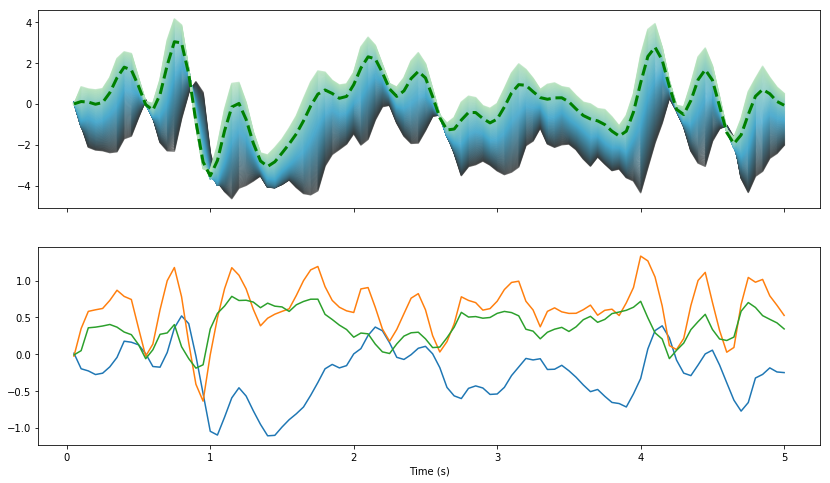

In [41]:
plot(sim.trange(), u, x)

### Alternative nengo_brainstorm Implementation

Here we re-implement the same network as above, but combine all of the dimensions into a single ensemble.

In [20]:
n_neurons = 248  # total

with nengo.Network() as model:
    u = nengo.Node(output=process, label='u')
    p_u = nengo.Probe(u, synapse=None)
    
    # This separate node is needed because we can't connect
    # from a node to an ensemble with a transform.
    Bu = nengo.Node(output=lambda _, u: map_hw.B.dot(u),
                    size_in=1, label='Bu')
    nengo.Connection(u, Bu, synapse=None)

    x = nengo.Ensemble(
        n_neurons=n_neurons, dimensions=len(sys), label='x', seed=0)

    nengo.Connection(Bu, x, synapse=tau)
    nengo.Connection(x, x, synapse=tau, function=lambda x: map_hw.A.dot(x))
    p = nengo.Probe(x, synapse=None)

In [21]:
with brd.Simulator(model, dt=dt, precompute_inputs=True) as sim:
    sim.run(length*dt)

HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs
decoder max(d) = 1  rmse=[0.36252884 0.30574252 0.23875991 0.37392957 0.35796469 0.53342224]
HAL: doing logical mapping
mapping results written to mapped_core.txt
HAL: programming mapping results to hardware
HAL: clearing hardware state
HAL: clearing queued-up outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

discarded 0 spikes and 0 outputs


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

disabling traffic


Radii: [0.10730479 0.47513347 1.18388281]


/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


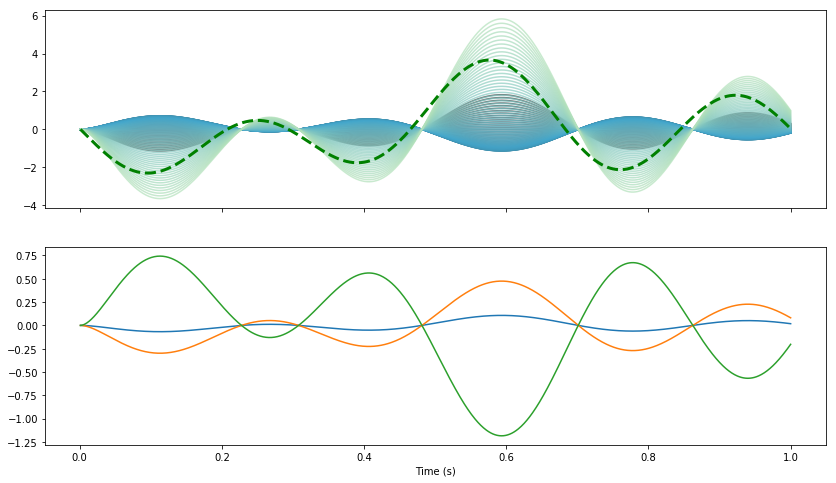

In [29]:
# TODO: de-duplicate code
u = np.asarray(sim.data[p_u]).squeeze()
x_raw = np.asarray(sim.data[p]).T
f = map_out.A.dot(x_raw) + map_out.B.dot(u[None, :])
x = syn_probe.filt(f, axis=1, dt=dt).T
plot(sim.trange(), u, x)

In [ ]:
# TODO: Make the above work better!